# **Table Of Contents**
1. Problem Statement
2. Data Description
3. Data Exploration and Visualization
4. Baseline Models (Majority Class, Linear Regression)
5. Final Model
6. Model Interpretation and Results
7. Conclusion

QUESTIONS FOR COREY:

- EDA for WSJ data?
- Model selection? Pair down?
- How much needs to be copied over from previous milestones?
    i.e. EDA???

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Problem Statement**

#### **Context**

Financial markets are highly sensitive to news and public sentiment, making accurate market predictions a challenging yet essential task for investors, analysts, and policymakers. Traditional methods of predicting stock market trends often rely on historical price data, technical indicators, and economic metrics, but they may overlook the impact of real-time news sentiment on market dynamics. This project aims to address this gap by leveraging the sentiment of headlines from the New York Times (NYT) and Wall Street Journal (WSJ) as a proxy for public and market sentiment. By analyzing how the tone and context of headlines correlate with movements in the S&P 500 index, we seek to uncover patterns that can complement existing predictive models. This approach reflects the growing importance of sentiment analysis in financial forecasting, recognizing the critical role that media and public perception play in shaping market behavior.

#### **Motivation**

The motivation for building a model to predict S&P 500 closing prices using the sentiments of New York Times (NYT) and Wall Street Journal (WSJ) headlines lies in the significant influence that public sentiment and news have on financial markets. Headlines often capture prevailing market sentiment, economic developments, and geopolitical events, which can drive investor behavior and, consequently, market movements. By analyzing the sentiment expressed in NYT headlines, we aim to extract valuable insights into market sentiment that could enhance traditional financial models. Integrating sentiment analysis with market prediction can improve the timeliness and accuracy of forecasts, providing a more comprehensive tool for investors and analysts to make informed decisions in a rapidly changing economic environment.

#### **Problem Statement** 

Using various sentiment analysis methods (VADER, TextBlob, BERT), we aim to compute sentiment scores for NYT headlines and WSJ headline between 1998 and 2020. Each headline includes a date and section field as well. NYT headlines were collected from 1990 to 2020 (avoiding harder to predict post-COVID fluctuations in the market). WSJ headlines were collected from 1998 to 2021. For this reason, we will use the years in overlap to perform sentiment analysis (1998 - 2020). Subsequent S&P 500 data closing prices have been collected at each time period during this timeframe, and we scaled these values to account for inflation.

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Our Approach**

We created a dataframe with an entry for each time point. For that time point, we average the sentiment scores for that day, and also add the number of headlines from each section into the row. Finally, our response is the S&P 500 closing price.

For the sentiment analysis, we used three different methods - VADER and TextBlob and BERT - to give a score to each NYT and WSJ article headline. Due to the short nature of each headline (on average 6 words or less), the majority of scores are 0, thus we exclude sentiment scores of 0 in order to assess either a positive or negative value for the time period - we will experiment with this threshold. It should be noted that there are many more headlines for the WSJ compared to the NYT, so we could only perform BERT on the WSJ enteries due to the computational time to incorporate this model. After testing multiple time points in milestones 4, we concluded that the average sentiment analysis for each month worked best to predict the S&P 500. This means we have a df where each row is a day date (averaged sentiment scores for that day and S&P closing price for that day), week (averaged sentiment scores for that day and averaged S&P closing price for that week) and so on.

#### **Datasets** 

For our **headline sentiment analysis**, we sourced two datasets -- New York Times headlines and Wall Street Journal headlines. These datasets are both cited from Kaggle.

1. Kaggle Wall Street Journal: https://www.kaggle.com/datasets/amogh7joshi/wsj-headline-classification/data

    The dataset consists of over 19,000 headlines scraped from the Wall Street Journal archives, spanning the period from May 3, 1998, to June 30, 2021. The headlines are organized into 67 categories based on the Wall Street Journal's classification system, making the dataset a valuable resource for tasks such as news category classification and unsupervised clustering. Headlines were randomly sampled (3-4 per day) and categorized, with categories containing fewer than 100 entries removed.

2. Kaggle New York Times: https://www.kaggle.com/datasets/johnbandy/new-york-times-headlines

    This dataset contains headlines from articles published by The New York Times between 1990 and 2020, along with accompanying metadata such as author, URL, word count, section, and more. It was created in July 2021 using The New York Times Article Search API. While it provides a comprehensive archive for text analysis and research, some records may have incomplete data due to API limitations.

For our **S&P closing prices**, we are using Python’s built-in Yahoo Finance function (yfinance) to pull historical stock market data and storing it in a dataframe.

#### **Dependencies**

TODO: write dependencies descriptions

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Data Exploration and Visualizations**

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Data Cleaning**

Loading data from csv's

In [3]:
archive_path = "archive"
dfs = []
for filename in os.listdir(archive_path):
    if filename.endswith(".csv") and filename.startswith("new_york_times_stories_"):
        file_path = os.path.join(archive_path, filename)
        
        df = pd.read_csv(file_path, dtype={"print_page": str})
        dfs.append(df)

data_nyt= pd.concat(dfs, ignore_index=True)
data_wsj = pd.read_csv("./archive/wsj_headlines.csv")

In [4]:
display(data_wsj.head())
display(data_nyt.head())

,date,headline,source,year,textblob_wsj,vader_nyt,bert_wsj_label,bert_wsj
0,2012-01-26 00:00:00+00:00,Mother Nature Raps Natural Gas,wsj,2012,0.1,0.3612,2,0.293945
1,2007-06-15 00:00:00+00:00,Subprime Woes Pinch Bear's Mortgage Star,wsj,2007,0.0,-0.4404,-2,0.287087
2,2011-01-24 00:00:00+00:00,Facebook Alters Tool in German Privacy Deal,wsj,2011,0.0,0.0000,-2,0.517856
3,2014-02-20 00:00:00+00:00,EU Ministers Clear Sanctions on Ukraine,wsj,2014,0.1,0.3818,1,0.228783
4,2011-01-09 00:00:00+00:00,Authorities Seek Possible Associate of Suspect,wsj,2011,0.0,-0.2960,-2,0.429186


,headline,source,word_count,url,print_section,print_page,author,type,pub_date,news_desk,section,year
0,Bridge,The New York Times,411.0,https://www.nytimes.com/1990/01/01/nyregion/br...,1,45.0,By Alan Truscott,article,1990-01-01T05:00:00+0000,Metropolitan Desk,New York,1990.0
1,He Has Tyson On His Mind,The New York Times,199.0,https://www.nytimes.com/1990/01/01/sports/spor...,1,38.0,By Phil Berger,article,1990-01-01T05:00:00+0000,Sports Desk,Sports,1990.0
2,"For Dinkins, Pomp, Ceremony, Triumph And a Dre...",The New York Times,1233.0,https://www.nytimes.com/1990/01/01/nyregion/fo...,1,27.0,By Don Terry,article,1990-01-01T05:00:00+0000,Metropolitan Desk,New York,1990.0
3,Army Doesn't Have to Compete With Marines; W...,The New York Times,524.0,https://www.nytimes.com/1990/01/01/opinion/l-a...,1,24.0,NaN,article,1990-01-01T05:00:00+0000,Editorial Desk,Opinion,1990.0
4,Students Must Get to School and Back Safely,The New York Times,363.0,https://www.nytimes.com/1990/01/01/opinion/l-s...,1,24.0,NaN,article,1990-01-01T05:00:00+0000,Editorial Desk,Opinion,1990.0


We will rename the columns of both csv's for consistence, they check their missigness to ensure our datset is complete. We will also align the start date to be July 1998 - January 2020.

In [5]:
# NYT headline data
df_nyt = data_nyt[["headline", "pub_date", "source"]].copy()
df_nyt = df_nyt[(df_nyt['pub_date'] >= '1998-07-01') & (df_nyt['pub_date'] < '2020-01-01')]
df_nyt.rename(columns={'pub_date': 'date'}, inplace=True)
df_nyt['date'] = pd.to_datetime(df_nyt['date'], errors='coerce', utc=True)
df_nyt["source"] = "nyt"

In [6]:
# WSJ headline data
df_wsj = data_wsj[["Date", "Headline"]].copy()
df_wsj['Date'] = pd.to_datetime(df_wsj['Date'], errors='coerce', utc=True)
df_wsj = df_wsj[(df_wsj['Date'] >= '1998-07-01') & (df_wsj['Date'] < '2020-01-01')]
df_wsj.rename(columns={'Date': 'date', 'Headline': 'headline'}, inplace=True)
df_wsj["source"] = "wsj"

KeyError: "None of [Index(['Date', 'Headline'], dtype='object')] are in the [columns]"

In [ ]:
display(df_nyt.head())
display(df_wsj.head())

,headline,date,source
742544,Lithium Battery Ban? Check Again,2008-01-01 00:02:35+00:00,nyt
742545,New Year’s Day Bowl Matchups,2008-01-01 00:21:03+00:00,nyt
742546,"Eight Years, And Back To The Start",2008-01-01 00:33:08+00:00,nyt
742547,Tackling Clutter to Improve Your Health,2008-01-01 01:11:43+00:00,nyt
742548,World Juniors: U.S. and Sweden Run the Table i...,2008-01-01 01:26:38+00:00,nyt


,date,headline,source
0,2012-01-26 00:00:00+00:00,Mother Nature Raps Natural Gas,wsj
1,2007-06-15 00:00:00+00:00,Subprime Woes Pinch Bear's Mortgage Star,wsj
2,2011-01-24 00:00:00+00:00,Facebook Alters Tool in German Privacy Deal,wsj
3,2014-02-20 00:00:00+00:00,EU Ministers Clear Sanctions on Ukraine,wsj
4,2011-01-09 00:00:00+00:00,Authorities Seek Possible Associate of Suspect,wsj


In [ ]:
# Check for missingness
print("NYT Headline Missingness Summary")
display(df_nyt.isnull().sum())

print("WSJ Headline Missingness Summary")
display(df_wsj.isnull().sum())

NYT Headline Missingness Summary


headline    565
date          0
source        0
dtype: int64

WSJ Headline Missingness Summary


date        0
headline    0
source      0
dtype: int64

In [ ]:
df_nyt = df_nyt.dropna(subset=["headline"])
display(df_nyt.isnull().sum())

headline    0
date        0
source      0
dtype: int64

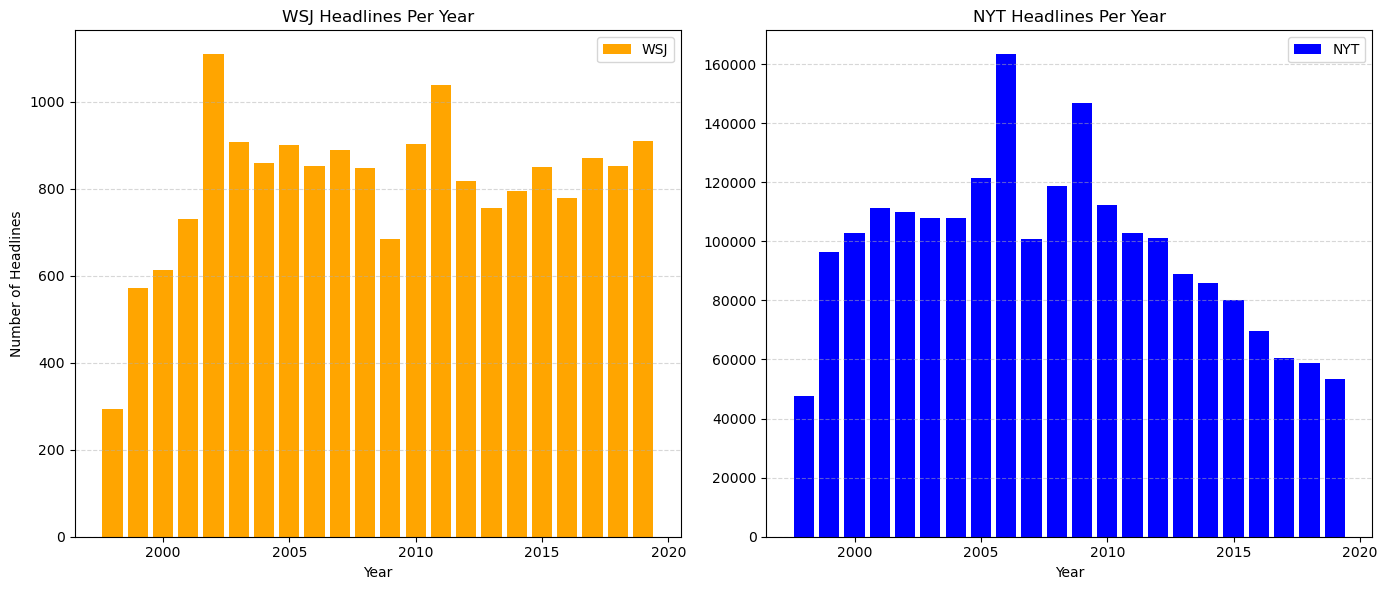

In [ ]:
df_wsj['year'] = df_wsj['date'].dt.year
df_nyt['year'] = df_nyt['date'].dt.year

# Filter and count headlines for WSJ and NYT by year
wsj_headlines_per_year = df_wsj[df_wsj['source'].str.lower() == 'wsj'].groupby('year')['headline'].count()
nyt_headlines_per_year = df_nyt[df_nyt['source'].str.lower() == 'nyt'].groupby('year')['headline'].count()

# Create side-by-side plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# WSJ Headlines Plot
axs[0].bar(wsj_headlines_per_year.index, wsj_headlines_per_year.values, color='orange', label='WSJ')
axs[0].set_title('WSJ Headlines Per Year')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Headlines')
axs[0].grid(axis='y', linestyle='--', alpha=0.5)
axs[0].legend()

# NYT Headlines Plot
axs[1].bar(nyt_headlines_per_year.index, nyt_headlines_per_year.values, color='blue', label='NYT')
axs[1].set_title('NYT Headlines Per Year')
axs[1].set_xlabel('Year')
axs[1].grid(axis='y', linestyle='--', alpha=0.5)
axs[1].legend()
plt.tight_layout()
plt.show()

## Sentiment Analysis

In [ ]:
def get_textblob_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df_nyt['textblob_nyt'] = df_nyt['headline'].apply(get_textblob_sentiment)
df_wsj['textblob_wsj'] = df_wsj['headline'].apply(get_textblob_sentiment)

In [ ]:
vader_analyzer = SentimentIntensityAnalyzer()
def get_vader_sentiment(text):
    scores = vader_analyzer.polarity_scores(text)
    return scores['compound']

# Apply VADER sentiment to the 'Headline' column
df_nyt['vader_nyt'] = df_nyt['headline'].apply(get_vader_sentiment)
df_wsj['vader_wsj'] = df_wsj['headline'].apply(get_vader_sentiment)


In [ ]:
# Load the pretrained model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Define a function for BERT sentiment analysis
def bert_sentiment_analysis(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    scores = torch.nn.functional.softmax(outputs.logits, dim=1)
    sentiment_score = torch.argmax(scores).item()  # Get the index of the highest score
    confidence = torch.max(scores).item()          # Get the confidence score
    return sentiment_score, confidence


In [ ]:
sentiments = []
confidences = []
for text in tqdm(df_wsj['headline'], desc="Analyzing Sentiment"):
    try:
        sentiment, confidence = bert_sentiment_analysis(text)
        sentiments.append(sentiment)
        confidences.append(confidence)
    except Exception as e:
        print(f"Error processing text: {text}\nError: {e}")
        sentiments.append(None)
        confidences.append(None)

df_wsj['bert_wsj_label'] = sentiments - 2
df_wsj['bert_wsj_confidence'] = confidences
df_wsj['bert_wsj'] = df_wsj['bert_wsj_label'] * df_wsj['bert_wsj_confidence']

Analyzing Sentiment:   0%|          | 1/17834 [00:00<44:43,  6.65it/s]

Analyzing Sentiment: 100%|██████████| 17834/17834 [07:13<00:00, 41.13it/s]


In [ ]:
display(df_wsj)

,date,headline,source,year,textblob_wsj,vader_nyt,bert_wsj_label,bert_wsj,bert_score_wsj
0,2012-01-26 00:00:00+00:00,Mother Nature Raps Natural Gas,wsj,2012,0.100000,0.3612,2,0.293945,0.587890
1,2007-06-15 00:00:00+00:00,Subprime Woes Pinch Bear's Mortgage Star,wsj,2007,0.000000,-0.4404,-2,0.287087,-0.574175
2,2011-01-24 00:00:00+00:00,Facebook Alters Tool in German Privacy Deal,wsj,2011,0.000000,0.0000,-2,0.517856,-1.035712
3,2014-02-20 00:00:00+00:00,EU Ministers Clear Sanctions on Ukraine,wsj,2014,0.100000,0.3818,1,0.228783,0.228783
4,2011-01-09 00:00:00+00:00,Authorities Seek Possible Associate of Suspect,wsj,2011,0.000000,-0.2960,-2,0.429186,-0.858372
...,...,...,...,...,...,...,...,...,...
19222,2001-03-11 00:00:00+00:00,Japan Unveils Emergency Economic Plan,wsj,2001,0.200000,-0.3818,2,0.403317,0.806634
19223,2008-09-04 00:00:00+00:00,Corning Guidance Hits Shares,wsj,2008,0.000000,0.2960,2,0.469164,0.938329
19224,2008-09-19 00:00:00+00:00,China's Market Intervention May Backfire,wsj,2008,0.000000,0.0000,-2,0.339890,-0.679781
19225,1999-01-31 00:00:00+00:00,REIT Trading Volume Sets Record,wsj,1999,0.000000,0.0000,2,0.381238,0.762476


## Scaling

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))

# Check and scale columns in df_wsj
for col in ['bert_score_wsj', 'textblob_wsj', 'vader_wsj']:
    df_wsj[col] = scaler.fit_transform(df_wsj[[col]])

# Check and scale columns in df_nyt
for col in ['textblob_nyt', 'vader_nyt']:
    df_nyt[col] = scaler.fit_transform(df_nyt[[col]])

NameError: name 'df_wsj' is not defined

_______________

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# TextBlob Sentiment
plt.subplot(1, 3, 1)
plt.hist(df['TextBlob_Sentiment'], bins=30, color='skyblue', edgecolor='black')
plt.title("TextBlob Sentiment Distribution")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")

# VADER Sentiment
plt.subplot(1, 3, 2)
plt.hist(df['VADER_Sentiment'], bins=30, color='coral', edgecolor='black')
plt.title("VADER Sentiment Distribution")
plt.xlabel("Compound Sentiment Score")
plt.ylabel("Frequency")

# BERT Sentiment
plt.subplot(1, 3, 3)
plt.hist(df['BERT_Sentiment_Score'], bins=30, color='lightgreen', edgecolor='black')
plt.title("BERT Sentiment Distribution")
plt.xlabel("Sentiment Confidence Score")
plt.ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv("./archive/wsj_headlines_with_sentiment.csv")

# Initialize MinMaxScaler for range -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the sentiment columns
df['Scaled_TextBlob_Sentiment'] = scaler.fit_transform(df[['TextBlob_Sentiment']])
df['Scaled_VADER_Sentiment'] = scaler.fit_transform(df[['VADER_Sentiment']])
df['Scaled_BERT_Sentiment_Score'] = scaler.fit_transform(df[['BERT_Sentiment_Score']])

# Display the first few rows to verify the new scaled columns
print("DataFrame with scaled sentiment columns:")
display(df.head())


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))

# TextBlob Sentiment
plt.subplot(1, 3, 1)
plt.hist(df['Scaled_TextBlob_Sentiment'], bins=30, color='skyblue', edgecolor='black')
plt.title("TextBlob Sentiment Distribution")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")

# VADER Sentiment
plt.subplot(1, 3, 2)
plt.hist(df['Scaled_VADER_Sentiment'], bins=30, color='coral', edgecolor='black')
plt.title("VADER Sentiment Distribution")
plt.xlabel("Compound Sentiment Score")
plt.ylabel("Frequency")

# BERT Sentiment
plt.subplot(1, 3, 3)
plt.hist(df['Scaled_BERT_Sentiment_Score'], bins=30, color='lightgreen', edgecolor='black')
plt.title("BERT Sentiment Distribution")
plt.xlabel("Sentiment Confidence Score")
plt.ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
import pandas as pd

# Load the dataset with headlines
# df = pd.read_csv("./archive/wsj_headlines_with_sentiment.csv")

# Get the start and end dates from the dataset
start_date = pd.to_datetime(df['Date']).min().strftime('%Y-%m-%d')
end_date = pd.to_datetime(df['Date']).max().strftime('%Y-%m-%d')

# Fetch S&P 500 data from Yahoo Finance with monthly intervals
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(start=start_date, end=end_date, interval="1mo")  # Monthly intervals

# Extract only the closing price
monthly_closing_prices = sp500_data[['Close']]

# Reset the index to have Date as a column for easier merging/inspection
monthly_closing_prices.reset_index(inplace=True)
monthly_closing_prices['Date'] = monthly_closing_prices['Date'].dt.strftime('%Y-%m')

# Display the first few rows of the monthly closing prices
print("Monthly Closing Prices of S&P 500:")
print(monthly_closing_prices.head())


In [ ]:
print(df.columns)


In [ ]:
# Ensure the 'Date' column in the headlines DataFrame is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract year and month for grouping
df['YearMonth'] = df['Date'].dt.to_period('M').astype(str)

# Group by YearMonth and calculate the average scaled sentiment scores
monthly_sentiments = df.groupby('YearMonth').agg({
    'Scaled_TextBlob_Sentiment': 'mean',
    'Scaled_VADER_Sentiment': 'mean',
    'Scaled_BERT_Sentiment_Score': 'mean'
}).reset_index()


In [ ]:
# Ensure the monthly closing prices DataFrame is a new copy to avoid SettingWithCopyWarning
monthly_closing_prices = monthly_closing_prices.copy()

# Add 'YearMonth' column in YYYY-MM format
monthly_closing_prices['YearMonth'] = monthly_closing_prices['Date']

# Drop the 'Date' column
monthly_closing_prices.drop(columns=['Date'], inplace=True)

# Merge the sentiment DataFrame with the S&P 500 monthly closing prices
final_monthly_df = pd.merge(monthly_sentiments, monthly_closing_prices, on='YearMonth', how='inner')

# Display the new DataFrame
print("Final Monthly DataFrame:")
display(final_monthly_df.head())

# Save the final DataFrame to a CSV file for future use
final_monthly_df.to_csv("./final_monthly_data.csv", index=False)
print("Data saved to 'final_monthly_data.csv'")

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Merge the monthly sentiments with S&P500 closing prices
final_monthly_df = pd.merge(monthly_sentiments, monthly_closing_prices, on='YearMonth', how='inner')

# Initialize MinMaxScaler for range -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Scale the S&P500 monthly closing prices
final_monthly_df['Scaled_SP500_Close'] = scaler.fit_transform(final_monthly_df[['Close']])

# Display the updated DataFrame
print("Final Monthly DataFrame with Scaled S&P500 Closing Prices:")
display(final_monthly_df.head())


In [ ]:
import seaborn as sns
final_monthly_df['YearMonth'] = pd.to_datetime(final_monthly_df['YearMonth'])

# Set up the plotting area with 3 side-by-side subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.set_style("whitegrid")

# Plot 1: Scaled TextBlob Sentiment vs Scaled S&P500 with hue as date
sns.scatterplot(
    data=final_monthly_df,
    x='Scaled_TextBlob_Sentiment',
    y='Scaled_SP500_Close',
    hue='YearMonth',
    palette='coolwarm',
    ax=axes[0],
    legend=False
)
axes[0].set_title("TextBlob Sentiment vs S&P500", fontsize=12)
axes[0].set_xlabel("Scaled TextBlob Sentiment")
axes[0].set_ylabel("Scaled S&P500 Close")

# Plot 2: Scaled VADER Sentiment vs Scaled S&P500 with hue as date
sns.scatterplot(
    data=final_monthly_df,
    x='Scaled_VADER_Sentiment',
    y='Scaled_SP500_Close',
    hue='YearMonth',
    palette='coolwarm',
    ax=axes[1],
    legend=False
)
axes[1].set_title("VADER Sentiment vs S&P500", fontsize=12)
axes[1].set_xlabel("Scaled VADER Sentiment")
axes[1].set_ylabel("")

# Plot 3: Scaled BERT Sentiment vs Scaled S&P500 with hue as date
sns.scatterplot(
    data=final_monthly_df,
    x='Scaled_BERT_Sentiment_Score',
    y='Scaled_SP500_Close',
    hue='YearMonth',
    palette='coolwarm',
    ax=axes[2],
    legend=False
)
axes[2].set_title("BERT Sentiment vs S&P500", fontsize=12)
axes[2].set_xlabel("Scaled BERT Sentiment")
axes[2].set_ylabel("")

# Adjust the layout for better appearance
plt.tight_layout()
plt.show()


In [ ]:
# Check if the scaled sentiment scores are within the range [-1, 1]
sentiment_columns = [
    'Scaled_TextBlob_Sentiment',
    'Scaled_VADER_Sentiment',
    'Scaled_BERT_Sentiment_Score'
]

for col in sentiment_columns:
    min_val = final_monthly_df[col].min()
    max_val = final_monthly_df[col].max()
    print(f"{col}: Min = {min_val}, Max = {max_val}")

# Check if any values are outside the range [-1, 1]
for col in sentiment_columns:
    out_of_range = final_monthly_df[(final_monthly_df[col] < -1) | (final_monthly_df[col] > 1)]
    if not out_of_range.empty:
        print(f"{col} has values outside the range [-1, 1]:")
        display(out_of_range)
    else:
        print(f"All values in {col} are within the range [-1, 1].")


In [ ]:
# Ensure 'YearMonth' is sorted in ascending order
final_monthly_df = final_monthly_df.sort_values(by='YearMonth')

# Extract the year from 'YearMonth' for splitting
final_monthly_df['Year'] = final_monthly_df['YearMonth'].dt.year

# Define the cutoff year for train-test split
test_start_year = final_monthly_df['Year'].max() - 4

# Create train and test datasets based on the cutoff year
train_data = final_monthly_df[final_monthly_df['Year'] < test_start_year]
test_data = final_monthly_df[final_monthly_df['Year'] >= test_start_year]

# Drop the 'Year' column as it's not needed for modeling
train_data = train_data.drop(columns=['Year'])
test_data = test_data.drop(columns=['Year'])

# Display the split information
print(f"Train data: {len(train_data)} rows")
print(f"Test data: {len(test_data)} rows")
display(train_data.head())
display(test_data.head())


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the target: 'Buy' or 'Sell' based on S&P500 close price changes
final_monthly_df['Target'] = (final_monthly_df['Close'].diff() > 0).astype(int)  # 1 for Buy (price went up), 0 for Sell (price went down)
final_monthly_df['Target'] = final_monthly_df['Target'].shift(-1)  # Shift to align with next month's decision
final_monthly_df = final_monthly_df.dropna(subset=['Target'])  # Drop rows with NaN in the target column

# Define features and target
feature_columns = ['Scaled_TextBlob_Sentiment', 'Scaled_VADER_Sentiment', 'Scaled_BERT_Sentiment_Score']
X = final_monthly_df[feature_columns]
y = final_monthly_df['Target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced'
)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot feature importance
import matplotlib.pyplot as plt

feature_importances = rf_classifier.feature_importances_
plt.figure(figsize=(8, 6))
plt.barh(feature_columns, feature_importances, color='skyblue')
plt.title("Feature Importance in Random Forest Classifier", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid()
plt.show()


In [ ]:
# Recreate the test data from the original DataFrame
test_data = final_monthly_df.iloc[-len(y_pred):].copy()  # Use the last rows corresponding to the predictions

# Add predictions and actual percentage changes to the test dataset
test_data['Predicted_Action'] = y_pred  # Add predictions
test_data['Actual_Change'] = test_data['Close'].pct_change()  # Actual percentage change
test_data = test_data.dropna(subset=['Actual_Change'])  # Drop rows with NaN in 'Actual_Change'

# Simulate returns
test_data['Simulated_Return'] = test_data.apply(
    lambda row: row['Actual_Change'] if row['Predicted_Action'] == 1 else 0,
    axis=1
)

# Calculate cumulative returns
cumulative_return = test_data['Simulated_Return'].sum()
print(f"Cumulative Return from Trading Strategy: {cumulative_return:.2%}")

# Compare with buy-and-hold strategy
buy_and_hold_return = test_data['Actual_Change'].sum()
print(f"Cumulative Return from Buy-and-Hold Strategy: {buy_and_hold_return:.2%}")

# Display key stats and check test_data structure
print("\nSimulated Test Data:")
display(test_data.head())


<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Problem Statment**

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Our Approach**

#### **Dependencies**
